# Transcription Factor Project - QC (Pipeline Steps A-F)
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:** What do TF KO effects reveal about:
* … the transcription regulatory network of hiPSCs, and TF crosstalk?
* … cell lineage?
* … how TFs influence chromatin remodeling?

***

# Import statements and global random seed

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import scipy as sp
#import re
#import requests
import gc
from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import delayed, parallel_backend, Parallel
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

# Set global random seed as safety measure for reproducibility
np.random.seed(92093)

# QC pipeline steps A-F

The `perturb_seq_heuristic_pipeline.py` file containing the QC and analysis pipeline from Nourreddine et al was imported as `qc`. Functions from `Pan_Genome_Analysis.ipynb`, a notebook containing additional code from Nourreddine et al, were pasted into a file `pan_genome_analysis_functions.py` which was imported as `qc2`.

## Initial data read-in

We will read in the Perturb-seq single-cell dataset `.h5mu` file as a `MuData` object, `mdata`.

`mdata` contains two modalities which are `AnnData` objects: `rna` (cell-by-gene matrix) and `crispr` (cell-by-knockout matrix)
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each human gene measured in the dataset
    - `.obs` = cell barcodes, `.var` = features = genes
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)
    - `.obs` = cell barcodes, `.var` = features = knockouts

We will be working with the `rna` modality for the majority of the analysis. We will assign it to the variable `adata`.

In [ ]:
md_filepath = "/home/ranwyl/data_tf_project/KOLF_Pan_Genome_Aggregate.h5mu"
mdata = mu.read_h5mu(md_filepath)
adata = mdata.mod["rna"]

In [ ]:
crispr = mdata.mod['crispr']

## Step B: Assigning sgRNA to cells and de facto doublet detection

The lists of cells and genes provided by the Mali lab are the output of step D; however, steps E through F require metadata annotation, meaning that it would make the most sense to run the pipeline on the `KOLF_Pan_Genome_Aggregate.h5mu` file through step F. First, we will run step B: assigning sgRNA to cells based on the protospacer calls and removing cells without exactly one sgRNA assigned (cells with < 1 sgRNA assigned must be removed, and cells with > 1 sgRNA assigned are considered de facto multiplets).

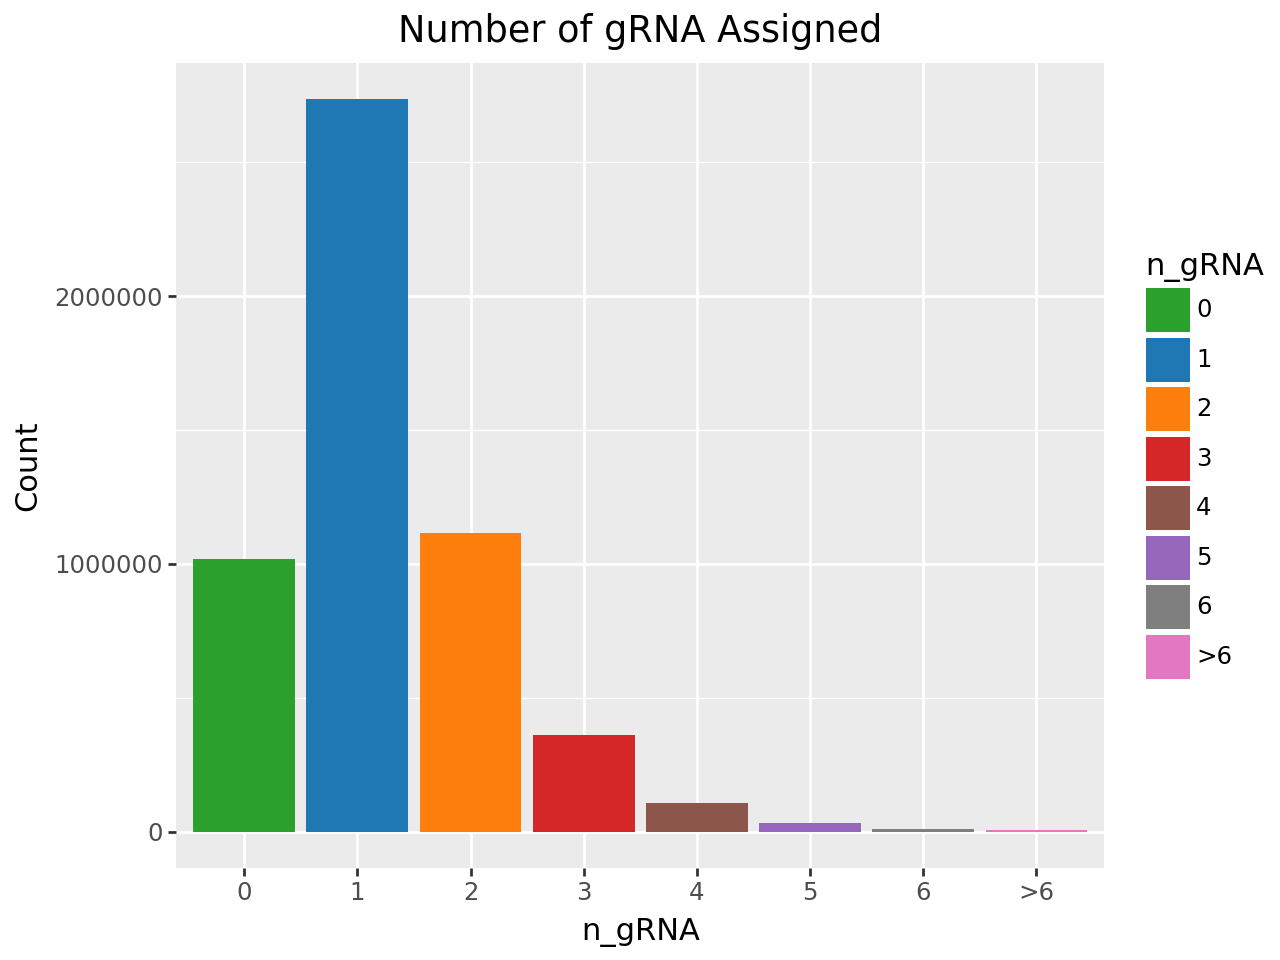

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


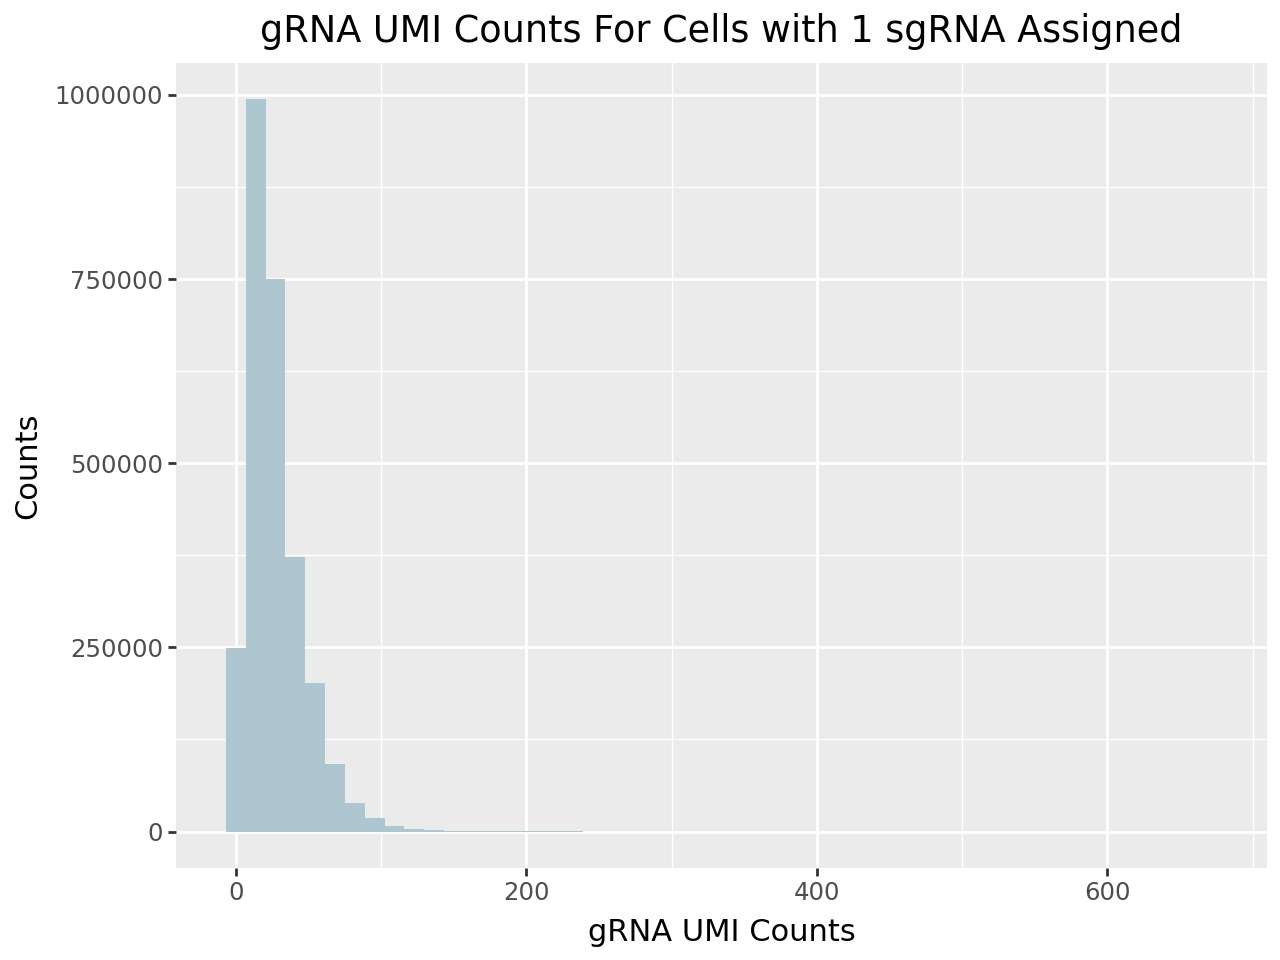

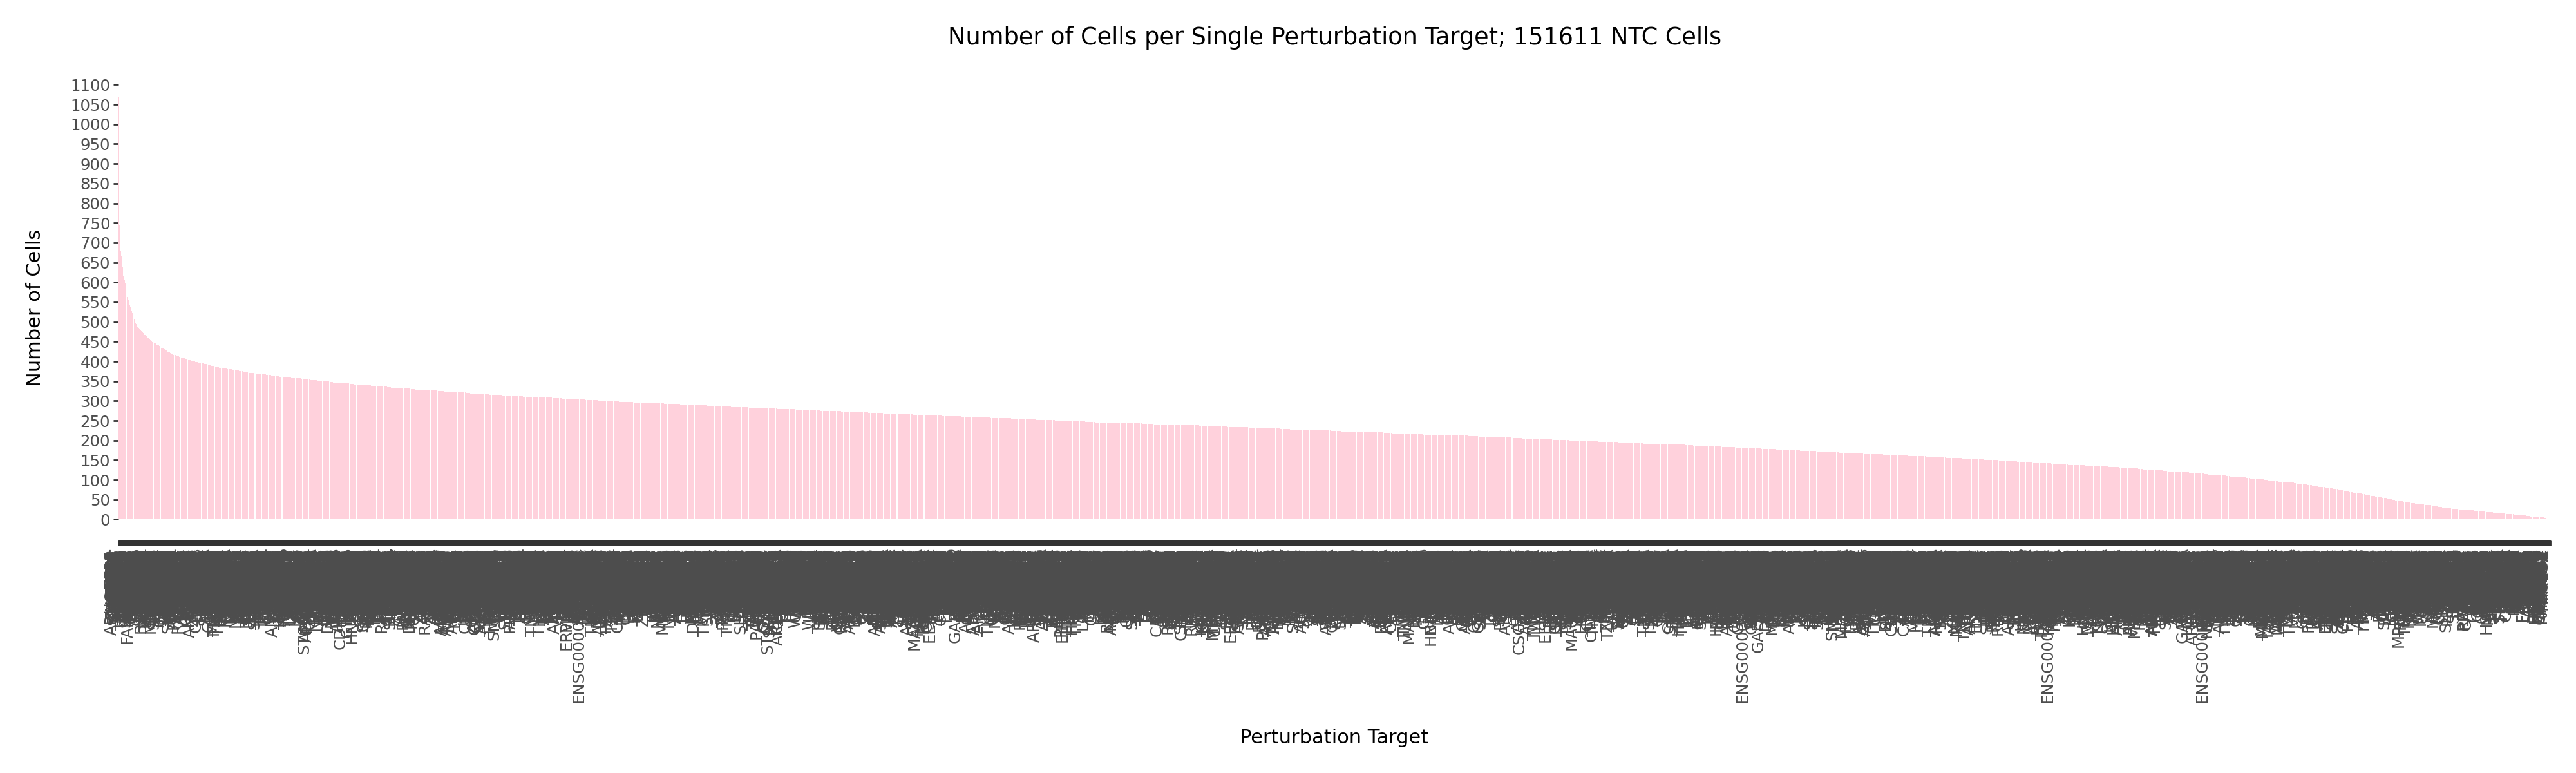

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)


In [ ]:
protospacer_calls_file_path = "/home/ranwyl/data_tf_project/protospacer_calls_per_cell.csv"
adata = qc.assign_protospacers(adata,protospacer_calls_file_path=protospacer_calls_file_path)

## Step C: Cell-level QC

Now we will run step C, cell-level QC. First, we assign metadata:

In [ ]:
aggregation_csv_file_path = "/home/ranwyl/data_tf_project/aggregation_csv.csv"
d = pd.read_csv(aggregation_csv_file_path)
channel_dict = {str(i+1):channel for i,channel in enumerate(d["sample_id"])}
adata = qc.assign_metadata(adata=adata,cell_type="KOLF2.1J iPSC",perturbation_type="CRISPRi Perturb-Seq",channel_dict=channel_dict)
adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Remove genes not detected in any cells

normalizing counts per cell
    finished (0:01:17)


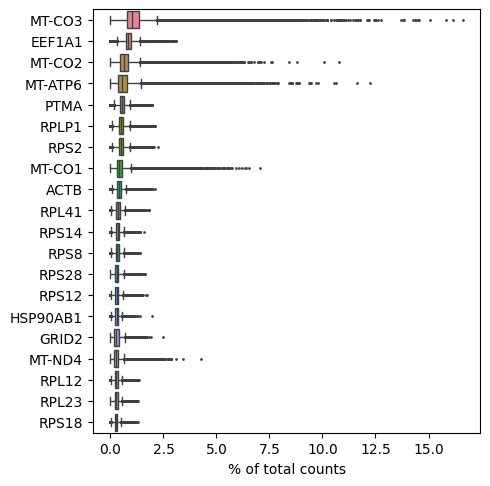

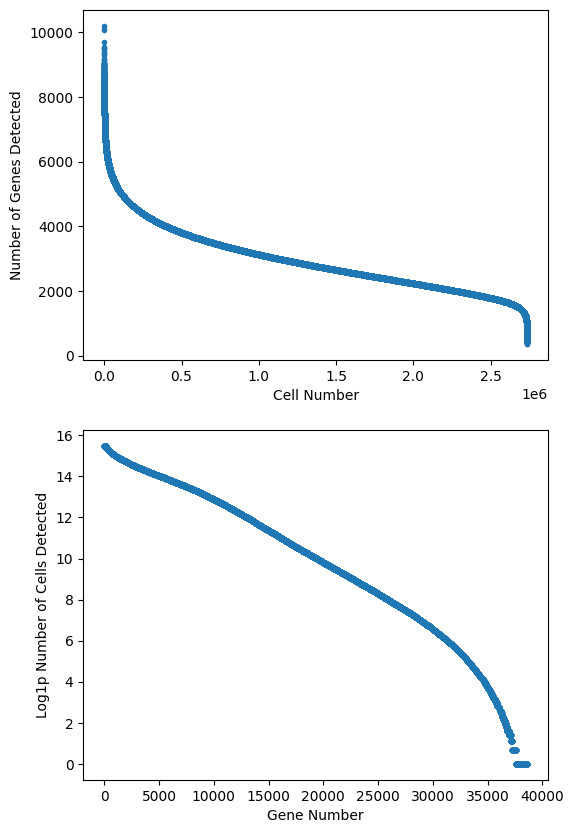

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

Perform QC with automatic thresholding based on median absolute deviations (MADs) for log1p_total_counts, lop1p_n_genes_by_counts, pct_counts_in_top_20_genes, and pct_counts_mt using scanpy's calculate_qc_metrics() with cumulative proportion to the 20th most expressed gene (percent_top=[20]).

Sept 7 2025: Filter on 3 count MADs and 5 mitochondrial MADs (see tf_project_qc_testing.ipynb for notes)

/home/ranwyl/data_tf_project/perturb_seq_heuristic_pipeline.py:201: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


outlier
False    2502888
True      232562
Name: count, dtype: int64

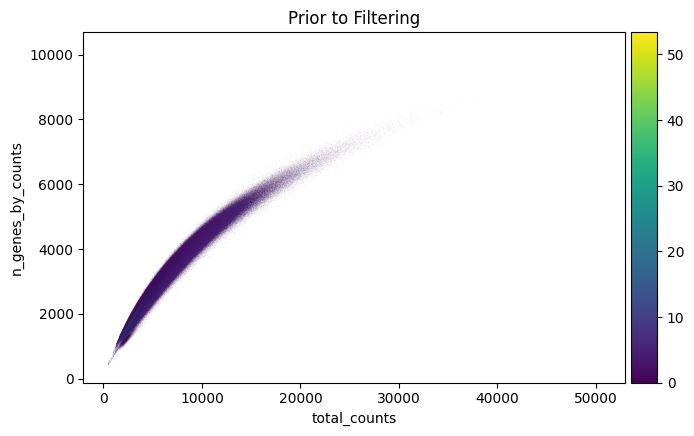

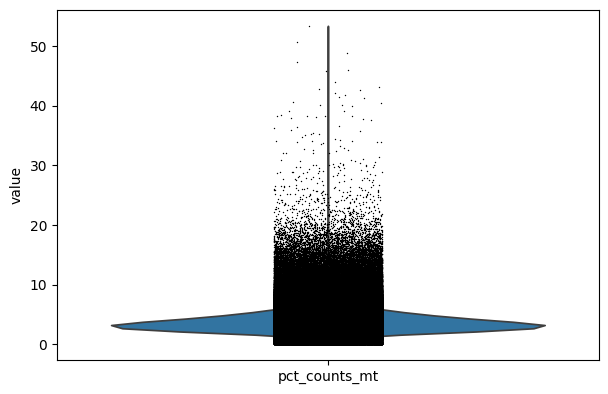

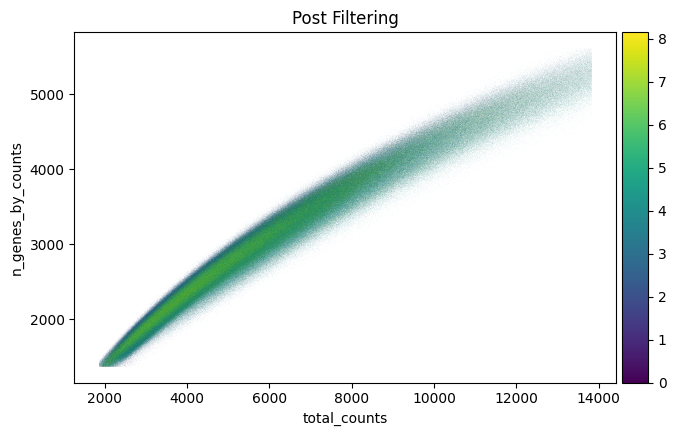

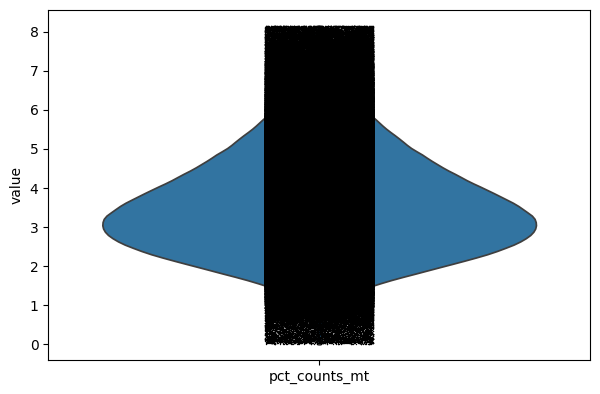

In [ ]:
adata35 = qc.dead_cell_qc(adata, count_MADs=3, mt_MADs=5, ribo_MADs=5)

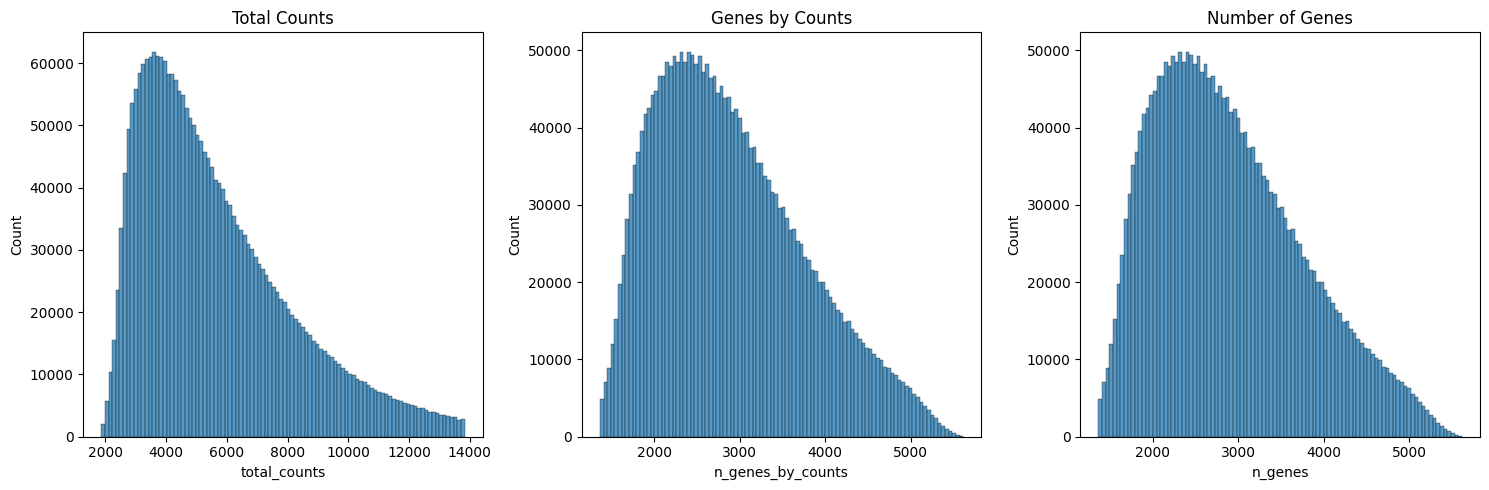

In [ ]:
qc.doublet_detection_sanity_check(adata35)

In [ ]:
adata35.write("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

## Filter cells (keep NTC cells that passed fitness testing and TF KO cells only) and genes (remove lowly expressed genes)

In [2]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_QC_Cell_QC.h5ad")

Save raw counts and create `run` metadata column in `obs`:

In [3]:
adata.layers["counts"] = adata.X.copy()
adata.obs["run"] = [label.split('-')[0] for label in adata.obs.channel]

In [4]:
adata

AnnData object with n_obs × n_vars = 2502888 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [5]:
adata.obs.perturbed.value_counts()

perturbed
True     2364614
False     138274
Name: count, dtype: int64

Filter NTC cells based on provided whitelist of NTC cells that passed fitness testing. Filter TF KO cells based on list of TFs from Lambert et al. (2018).

In [7]:
def filter_ntc_whitelist_and_tf_ko_cells(adata, ntc_filepath, tf_set):
    """
    Filter NTC cells based on provided whitelist of NTC cells that passed fitness testing.
    Filter KO cells that are TF KOs based on provided set of TFs.
    """
    with open(ntc_filepath, "r") as f:
        sgRNA_whitelist = f.read().splitlines()
    return adata[(adata.obs.gRNA.isin(sgRNA_whitelist)) | (adata.obs.gene_target.isin(tf_set))].copy()

In [8]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
lambert_tfs = set(lambert_tfs)

# NTC whitelist
whitelist_filepath = "/home/ranwyl/data_tf_project/NTC_sgRNA_whitelist.txt"

# Filter adata
adata = filter_ntc_whitelist_and_tf_ko_cells(adata, whitelist_filepath, lambert_tfs)

In [9]:
adata

AnnData object with n_obs × n_vars = 451878 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [10]:
adata.obs.perturbed.value_counts()

perturbed
True     401550
False     50328
Name: count, dtype: int64

Filter percentage of genes with lowest expression and genes expressed in a low number of cells

In [11]:
def filter_low_expressed_genes(adata, percent_threshold=None, min_n_cells=None):
    """
    Filter out bottom percentile of genes with lowest expression (normalized and
    log1p-transformed) and genes expressed in fewer than min_n_cells cells.
    """
    n_genes_before = adata.shape[1]
    # Create histogram layer, normalize, and log-transform
    layer_to_copy = adata.layers["counts"] if "counts" in adata.layers else adata.X
    adata.layers["histogram"] = layer_to_copy.copy()
    sc.pp.normalize_total(adata, layer="histogram")
    sc.pp.log1p(adata, layer="histogram")
    data_matrix = adata.layers["histogram"]

    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()
    
    # Filter genes expressed in fewer than min_n_cells cells
    if min_n_cells:
        gene_detected_counts = (data_matrix > 0).sum(axis=0)
        genes_pass_cell_thr = gene_detected_counts >= min_n_cells
        data_matrix = data_matrix[:, genes_pass_cell_thr].copy()
        adata = adata[:,genes_pass_cell_thr].copy()

    # Filter bottom percentile of genes by expression
    if percent_threshold:
        # Calculate mean expression of each gene
        col_values = data_matrix.mean(axis=0)
        # Set percent threshold and filter genes
        threshold = np.percentile(col_values, percent_threshold)
        genes_to_keep = col_values > threshold
        adata = adata[:,genes_to_keep].copy()
    
    print(f"Removed {n_genes_before - adata.shape[1]} genes")
    return adata

def histogram_mean_norm_expression(adata, title="Histogram of Mean Gene Expression", 
                              n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use normalized, log1p-transformed expression
    if "histogram" in adata.layers: # Holds norm + log1p expression values
        data_matrix = adata.layers["histogram"]
    else:
        layer_to_copy = adata.layers["counts"] if "counts" in adata.layers else adata.X
        adata.layers["histogram"] = layer_to_copy.copy()
        sc.pp.normalize_total(adata, layer="histogram")
        sc.pp.log1p(adata, layer="histogram")
        data_matrix = adata.layers["histogram"]
    # Convert from sparse to dense if necessary
    if hasattr(data_matrix, 'toarray'):
        data_matrix = data_matrix.toarray()
    # Plot mean expression
    mean_expr = data_matrix.mean(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(mean_expr, bins=n_bins, kde=False)
    plt.xlabel("Mean expression per gene (norm & log1p)")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()

def histogram_cells_expressing_gene(adata, title="Histogram of # Cells Expressing a Gene", 
                                    n_bins=75, ymax=None, show_labels=False):
    plt.rcParams["font.size"] = 14
    # Use raw counts
    count_matrix = adata.X if "counts" not in adata.layers else adata.layers["counts"]
    # Convert from sparse to dense if necessary
    if hasattr(count_matrix, 'toarray'):
        count_matrix = count_matrix.toarray()
    # Plot number of cells expressing each gene
    gene_detected_counts = (count_matrix > 0).sum(axis=0)
    plt.figure(figsize=(8,4)) if show_labels else plt.figure(figsize=(6,4))
    ax = sns.histplot(gene_detected_counts, bins=n_bins, kde=False)
    plt.xlabel("Number of cells in which gene is expressed")
    plt.ylabel("Number of genes")
    plt.title(title, fontsize=15)
    if ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        ax.bar_label(ax.containers[0], rotation=90, padding=3, fontsize=10)
    plt.tight_layout()
    plt.show()

Plot histograms before filtering genes

normalizing counts per cell
    finished (0:00:05)


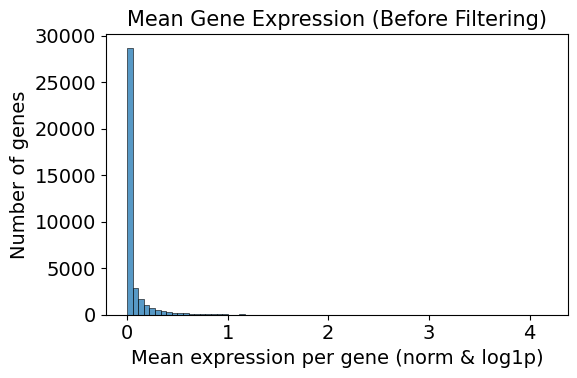

In [10]:
histogram_mean_norm_expression(adata, title="Mean Gene Expression (Before Filtering)")

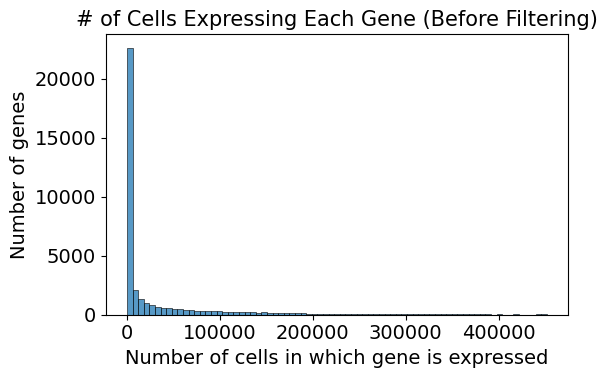

In [12]:
histogram_cells_expressing_gene(adata, title="# of Cells Expressing Each Gene (Before Filtering)")

Filter 30% of genes with lowest mean normalized+log1p-transformed expression and genes that are expressed in fewer than 100 cells

In [13]:
adata_filtered = filter_low_expressed_genes(adata, percent_threshold=30, min_n_cells=100)

normalizing counts per cell
    finished (0:00:14)
Removed 17902 genes


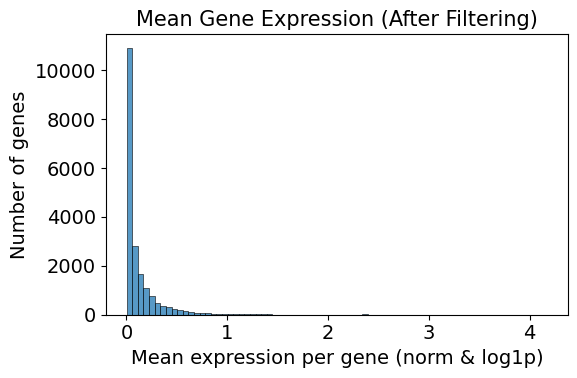

In [14]:
histogram_mean_norm_expression(adata_filtered, title="Mean Gene Expression (After Filtering)")

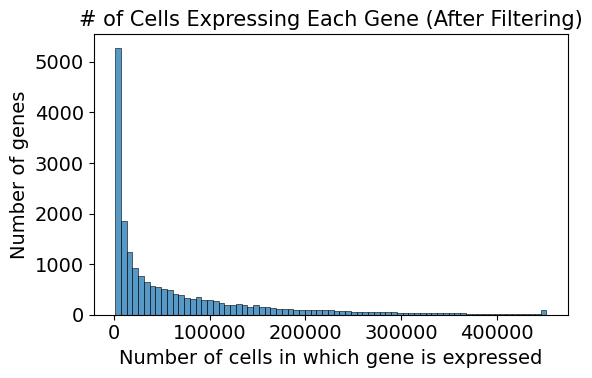

In [15]:
histogram_cells_expressing_gene(adata_filtered, title="# of Cells Expressing Each Gene (After Filtering)")

In [16]:
adata_filtered.write("/home/ranwyl/data_tf_project/Aggregate_Basic_Cell_Gene_QC.h5ad")

Restart kernel

## Step D: Isolating Core NTC Cells 

Read in QC-passed data:

In [2]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Basic_Cell_Gene_QC.h5ad")
adata

AnnData object with n_obs × n_vars = 451878 × 19665
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts', 'histogram'

### Step D with modified RNG functions and PCA random seed = 0

Use isolation forest model with 30% contamination fraction to isolate core NTC cells. Use modified version of scrub_ntc() that uses random seeds for PCA and isolation forest model:

Initial number of NTC Cells: 50328
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    555 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    429 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:06)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adat

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


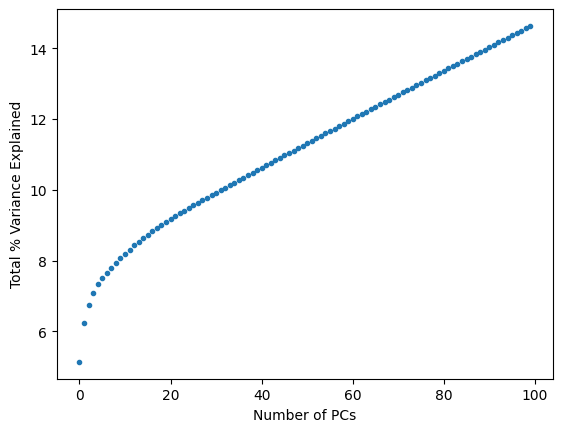

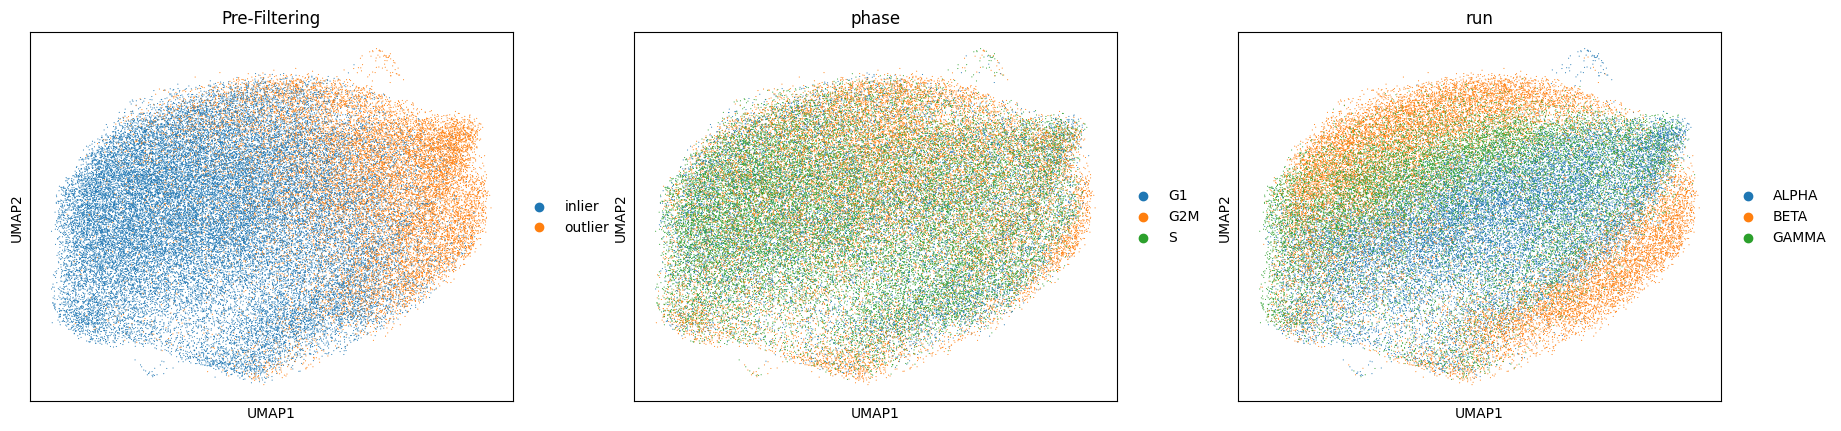

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


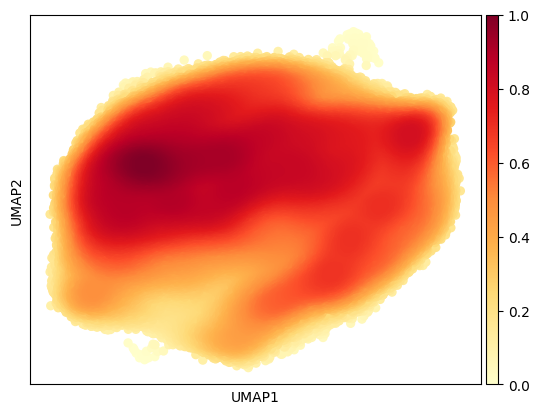

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    computed neighbors (0:00:01)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


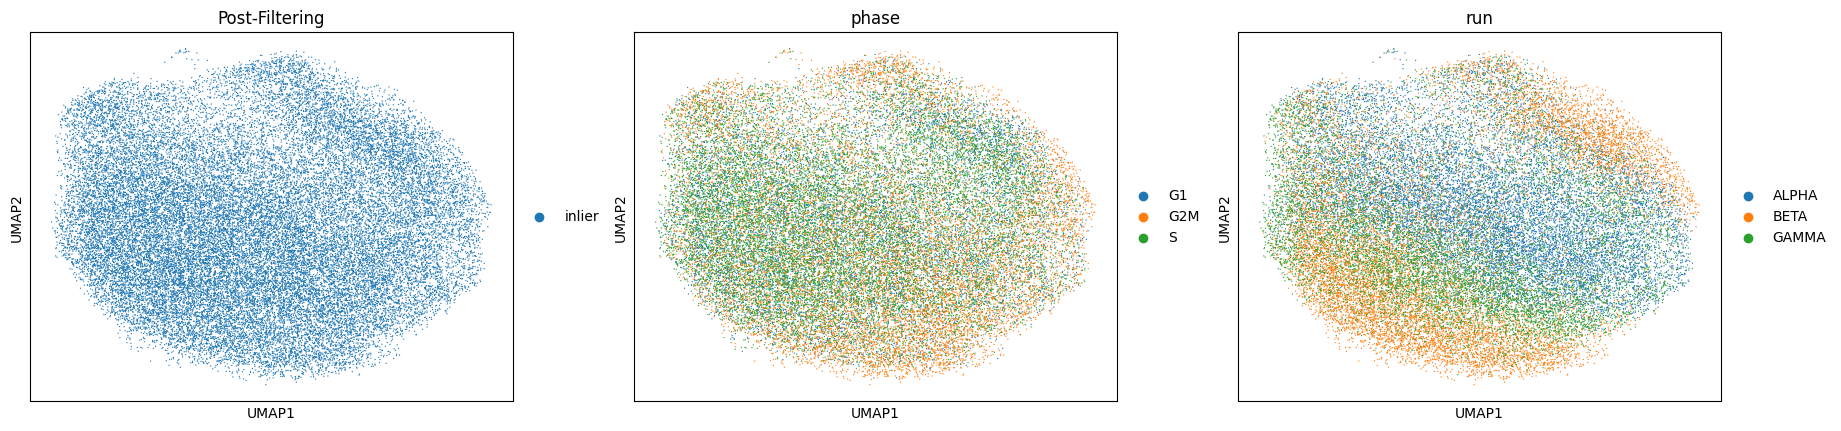

computing density on 'umap'
--> added
    'umap_density', densities (adata.obs)
    'umap_density_params', parameter (adata.uns)


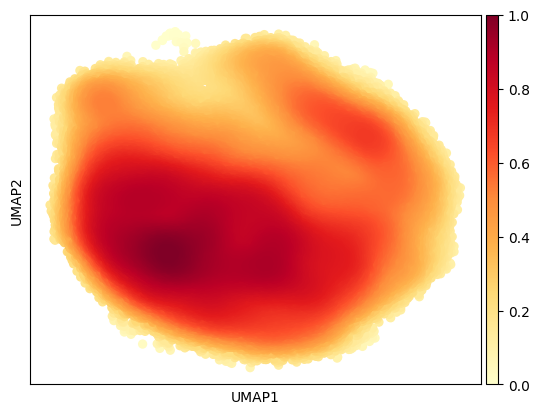

In [4]:
step_d_pca_seed = 0
step_d_isolation_forest_seed = 123

ntc_adata = adata[adata.obs.perturbed=="False"].copy()
ntc_adata = ntc_adata[ntc_adata.obs.index.isin(qc2.scrub_ntc_random_seed(ntc_adata, 
                                                                         rand_seed_pca=step_d_pca_seed, 
                                                                         rand_seed_isolation_forest=step_d_isolation_forest_seed))]

In [5]:
ntc_adata

View of AnnData object with n_obs × n_vars = 35229 × 19665
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'S_score', 'G2M_score', 'phase', 'is_outlier', 'umap_density'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'is_outlier_colors', 'phase_colo

In [6]:
ntc_adata.obs.run.value_counts()

run
ALPHA    13945
BETA     12055
GAMMA     9229
Name: count, dtype: int64

We have now isolated the core NTC cells. We will subset `adata` to only include perturbed cells and the core NTC cells.

In [7]:
perturbed_mask = adata.obs.perturbed == "True"
valid_ntc_mask = adata.obs.index.isin(ntc_adata.obs.index)
adata_step_d = adata[perturbed_mask | valid_ntc_mask,:].copy()

In [8]:
adata_step_d

AnnData object with n_obs × n_vars = 436779 × 19665
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    layers: 'counts', 'histogram'

Save the file:

In [ ]:
adata_step_d.write("/home/ranwyl/data_tf_project/Aggregate_Core_NTC_TF_KO.h5ad")

Restart kernel, then load in output from step D

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_Core_NTC_TF_KO.h5ad")

Check that the number of NTC cells is correct:

In [3]:
adata.obs.perturbed.value_counts()

perturbed
True     401550
False     35229
Name: count, dtype: int64

Plot cells per perturbation:

1578/11739 (13.44)% Perturbations have > 100 cells


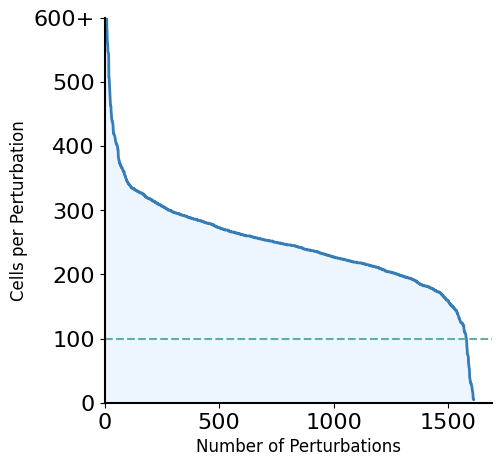

In [4]:
f = qc2.plot_cells_per_perturbation(adata)

Plot UMIs per cell:

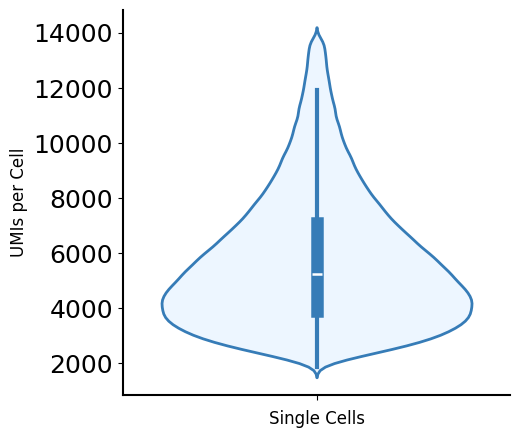

In [5]:
f = qc2.plot_umis_per_cell(adata)

Remove invalid gene targets:

In [6]:
gene_id_file_path = "/home/ranwyl/data_tf_project/gene_ids.txt"
qc2.assign_gene_ids(adata, gene_id_file_path)
adata = qc2.remove_invalid_gene_targets_in_place(adata,obs_key="gene_target_ensembl_id",var_key="gene_ids")

  - ENSG00000173253
  - ENSG00000139515
  - ENSG00000122691
  - ENSG00000141448
  - ENSG00000182983
  - ENSG00000121068
  - ENSG00000180053
  - ENSG00000164920
  - ENSG00000258873
  - ENSG00000213921
  - ENSG00000171116
  - ENSG00000198914
  - ENSG00000170178
  - ENSG00000107187
  - ENSG00000152784
  - ENSG00000165606
  - ENSG00000163792
  - ENSG00000205899
  - ENSG00000136535
  - ENSG00000105261
  - ENSG00000204779
  - ENSG00000175329
  - ENSG00000196350
  - ENSG00000260596
  - ENSG00000119508
  - ENSG00000111049
  - ENSG00000169953
  - ENSG00000173976
  - ENSG00000184937
  - ENSG00000136574
  - ENSG00000204335
  - ENSG00000176165
  - ENSG00000198353
  - ENSG00000160321
  - ENSG00000105672
  - ENSG00000164334
  - ENSG00000173825
  - ENSG00000273514
  - ENSG00000125492
  - ENSG00000169297
  - ENSG00000064835
  - ENSG00000166211
  - ENSG00000185610
  - ENSG00000152804
  - ENSG00000185002
  - ENSG00000164853
  - ENSG00000115844
  - ENSG00000143032
  - ENSG00000148826
  - ENSG00000092607


Split by run and save intermediate files:

In [7]:
adata_alpha = adata[adata.obs.run=="ALPHA"].copy()
adata_alpha.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_TF_KO.h5ad")

In [8]:
adata_beta = adata[adata.obs.run=="BETA"].copy()
adata_beta.write("/home/ranwyl/data_tf_project/Aggregate_BETA_TF_KO.h5ad")

In [9]:
adata_gamma = adata[adata.obs.run=="GAMMA"].copy()
adata_gamma.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_TF_KO.h5ad")

## Step E: Isolating effective sgRNA

### Step E with modified RNG functions (step D PCA random seed = 0)

In the knockdown QC step, we will normalize counts per cell to 1M, remove sgRNA that do not induce mean >30% on-target knockdown, and remove unrepressed cells and sgRNA without at least 25 associated cells. We will read in each dataset and perform knockdown QC one at a time.

Perform knockdown QC:

normalizing counts per cell
    finished (0:00:09)
8175 out of 11298 (72.36%) non-NTC sgRNAs have more than 30% knockdown.


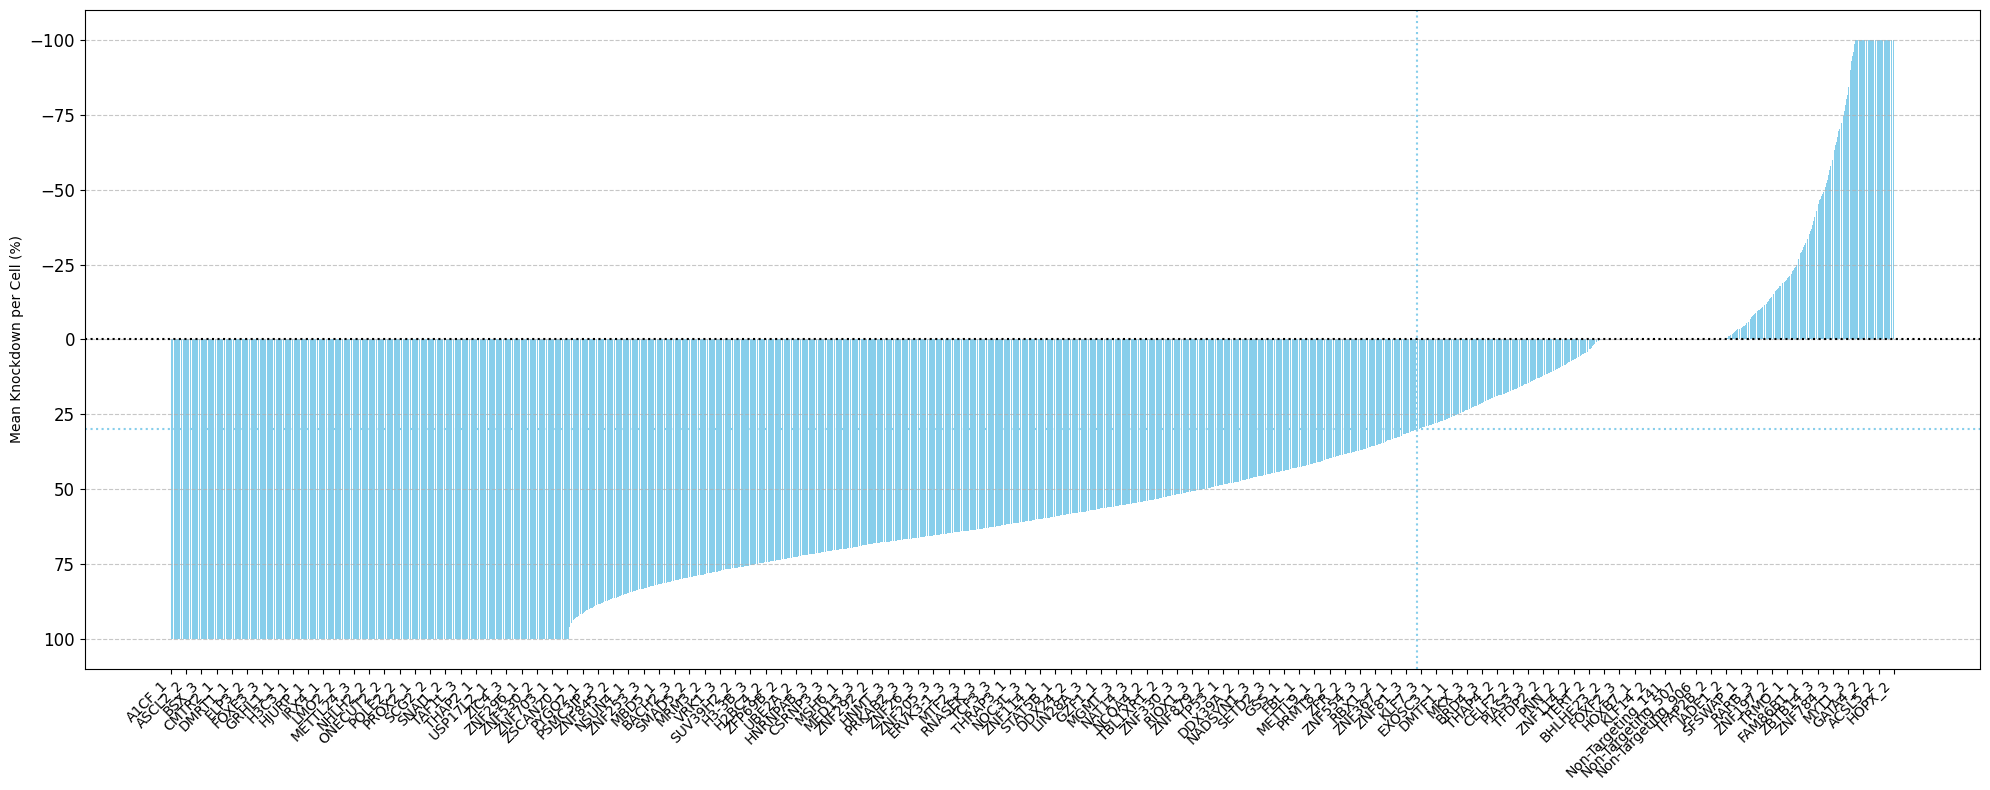

Removing 2887 perturbing sgRNA for not having more than 30% knockdown
Before filter: 11301,perturbed
True     840039
False     13298
Name: count, dtype: int64
After filter: 8414,perturbed
True     626334
False     13298
Name: count, dtype: int64
Removing 38096 perturbed cells for not having any measureable repression.
Before filter: 8414,perturbed
True     626334
False     13298
Name: count, dtype: int64
After filter: 8414,perturbed
True     588238
False     13298
Name: count, dtype: int64


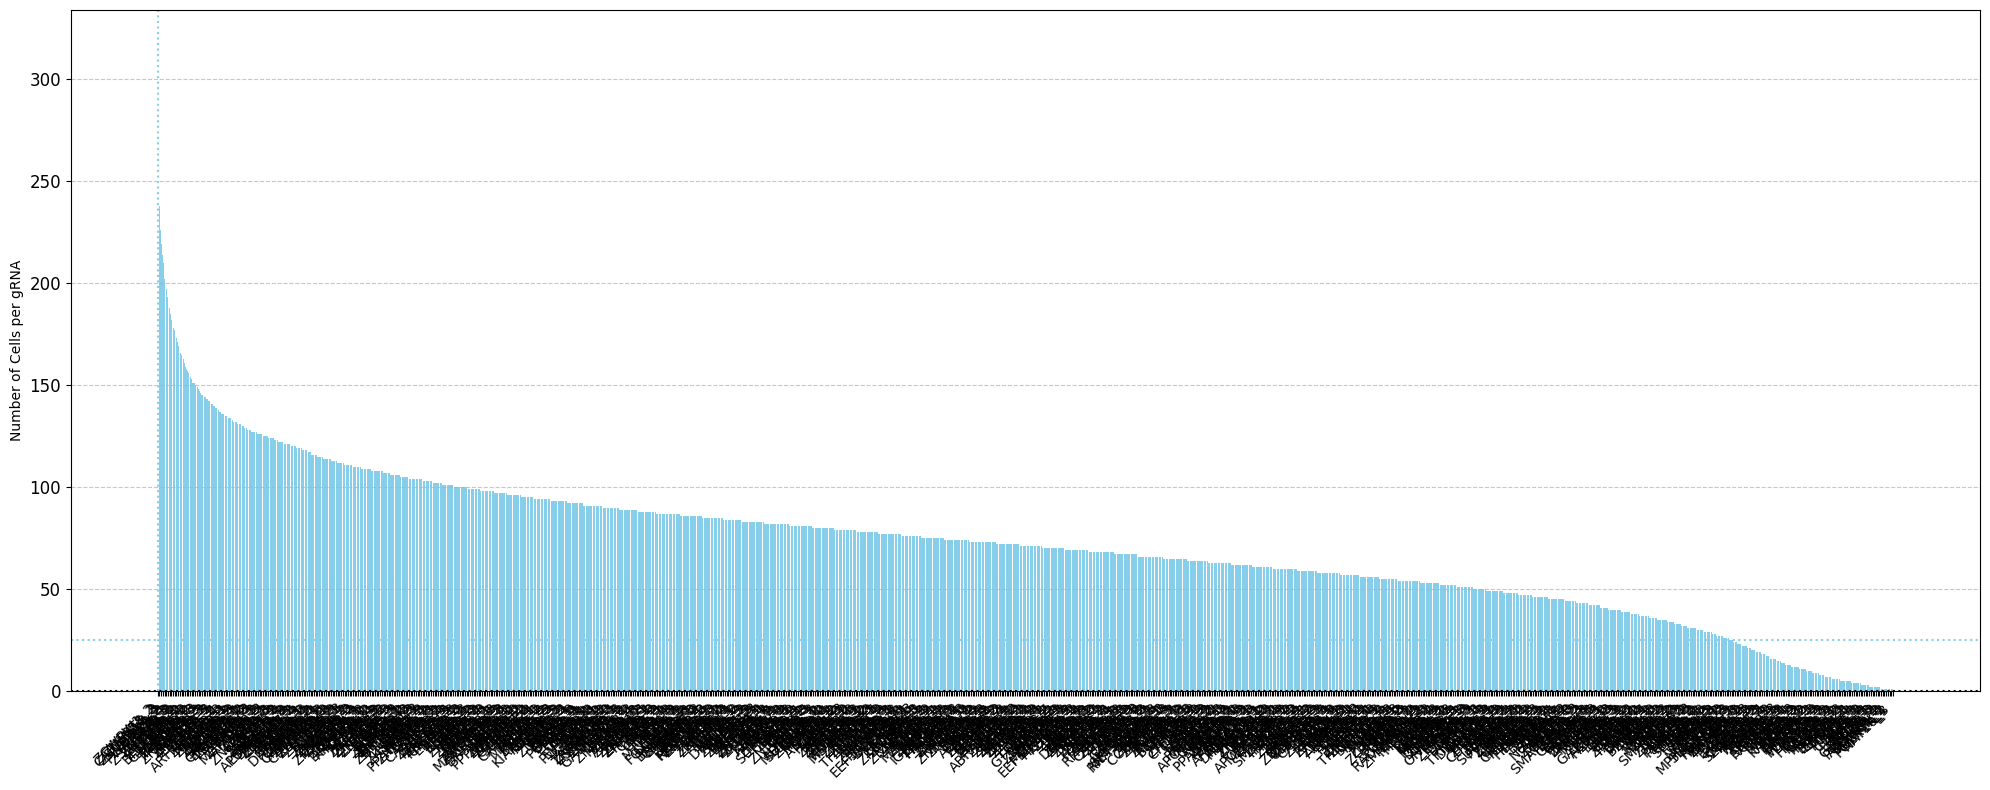

Before filter: 8414,perturbed
True     588238
False     13298
Name: count, dtype: int64
Removing 773 perturbing sgRNA for not having more than 25 cells
After filter: 7641,perturbed
True     579997
False     13298
Name: count, dtype: int64


In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_final.h5ad")
knockdown_adata_alpha = qc2.knockdown_qc(adata_alpha, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:12)
9831 out of 12153 (80.89%) non-NTC sgRNAs have more than 30% knockdown.


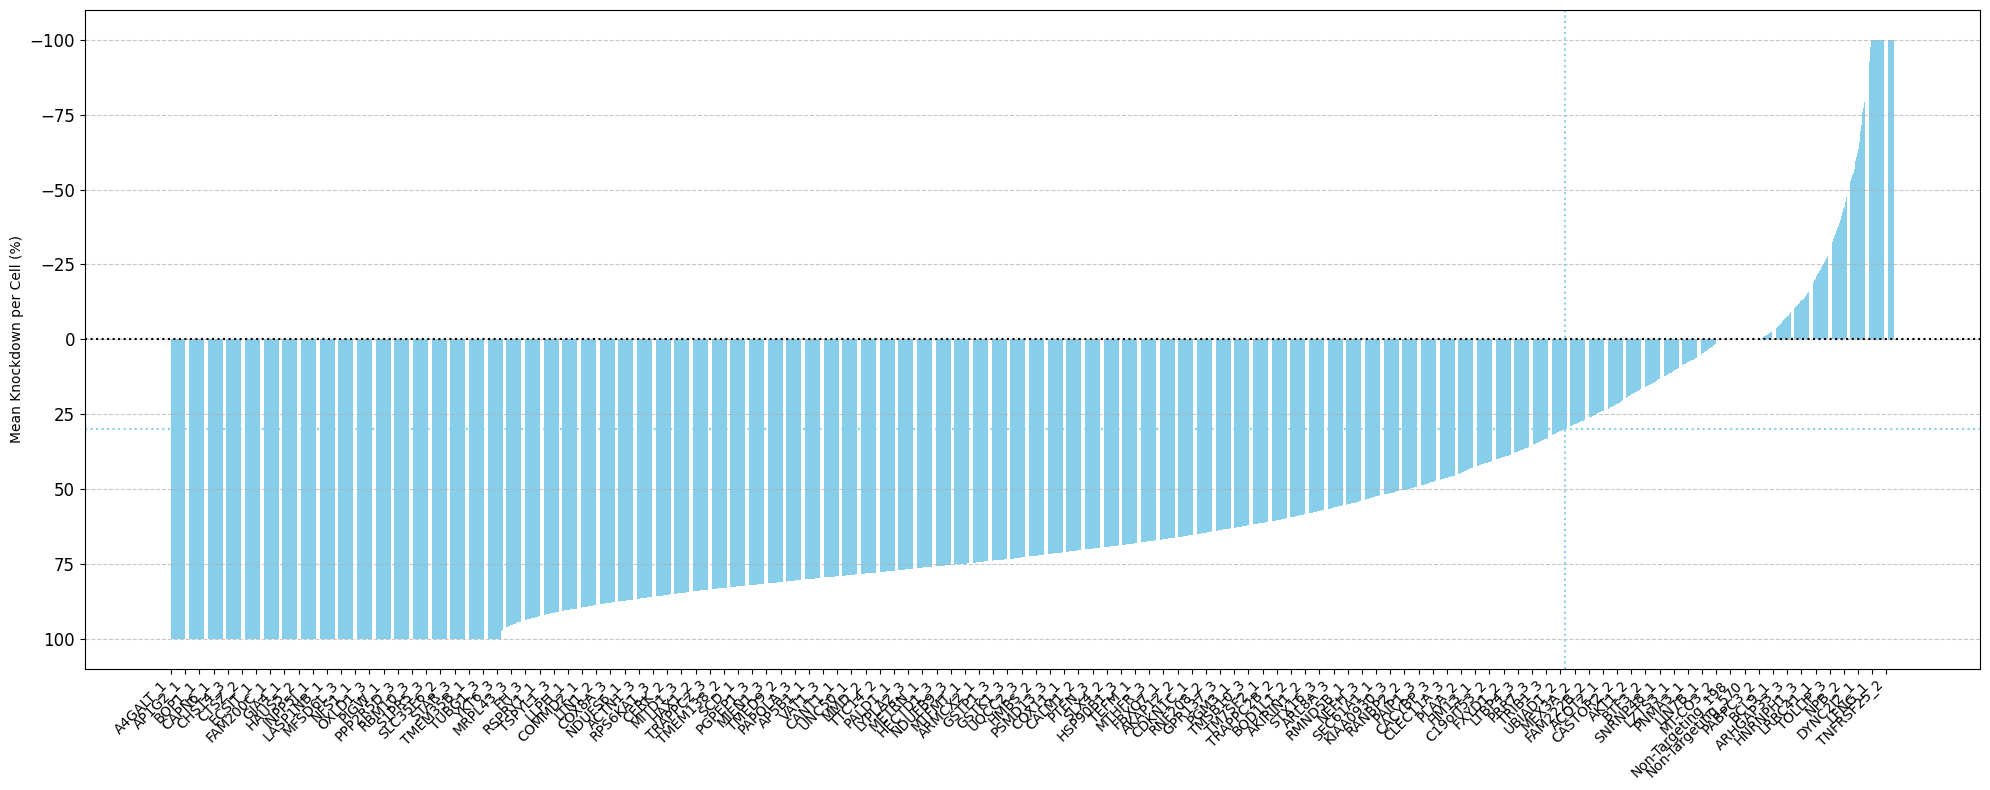

Removing 2086 perturbing sgRNA for not having more than 30% knockdown
Before filter: 12153,perturbed
True     884112
False     12750
Name: count, dtype: int64
After filter: 10067,perturbed
True     754529
False     12750
Name: count, dtype: int64
Removing 39483 perturbed cells for not having any measureable repression.
Before filter: 10067,perturbed
True     754529
False     12750
Name: count, dtype: int64
After filter: 10067,perturbed
True     715046
False     12750
Name: count, dtype: int64


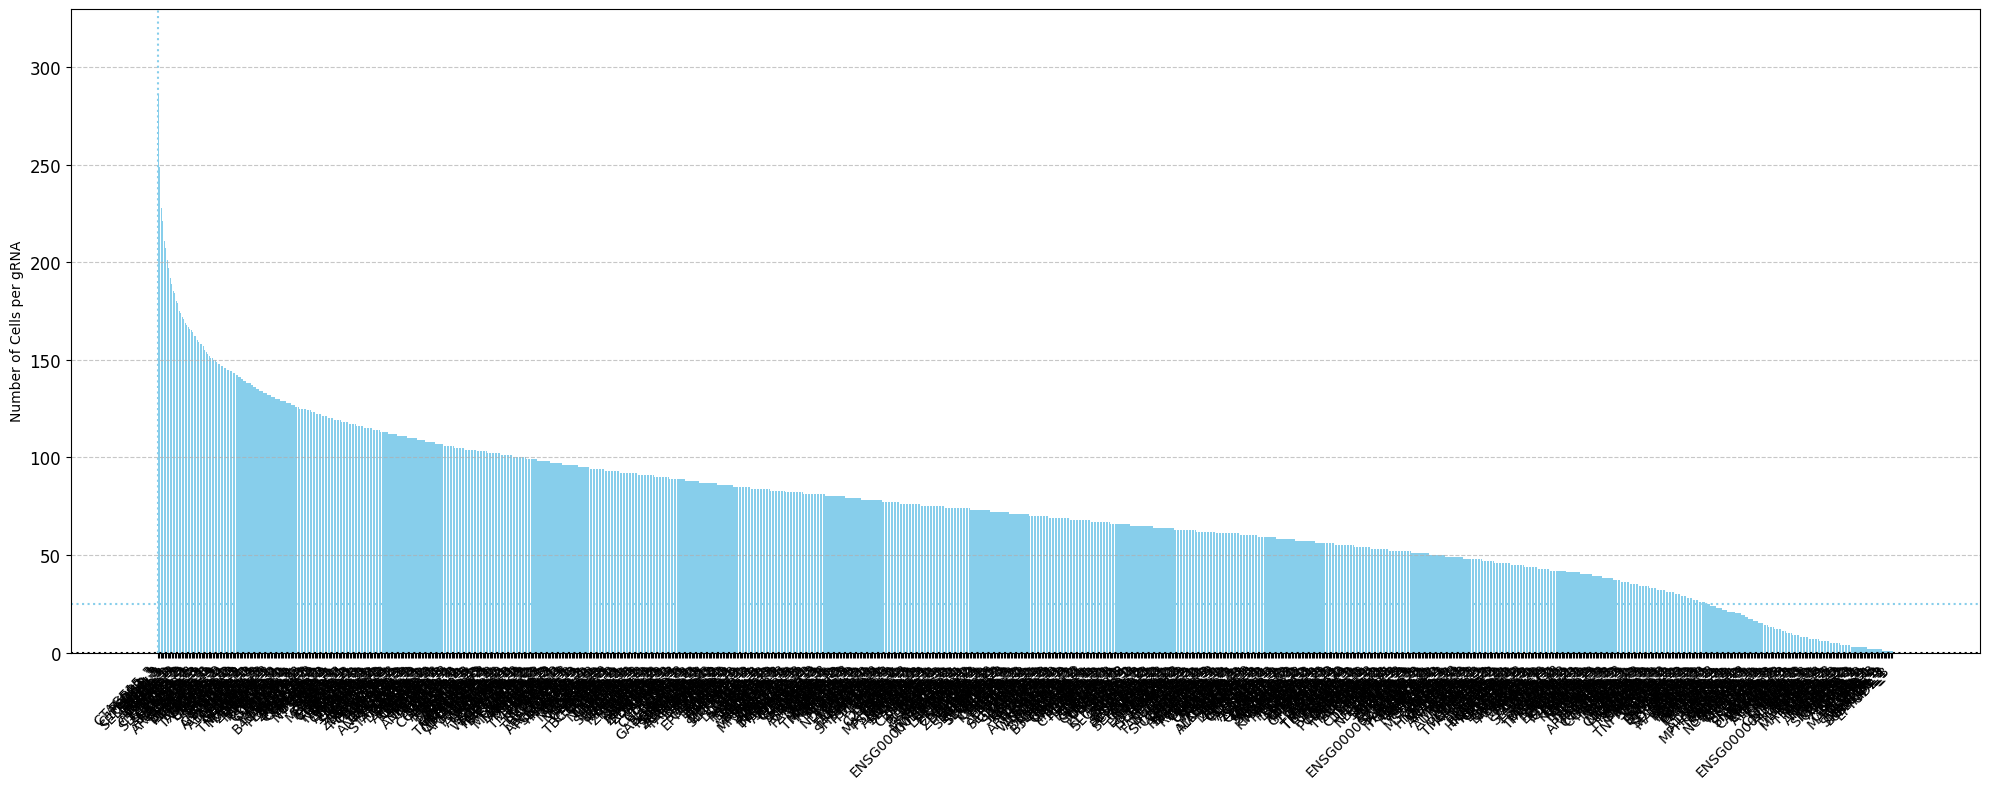

Before filter: 10067,perturbed
True     715046
False     12750
Name: count, dtype: int64
Removing 1066 perturbing sgRNA for not having more than 25 cells
After filter: 9001,perturbed
True     703808
False     12750
Name: count, dtype: int64


In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_final.h5ad")
knockdown_adata_beta = qc2.knockdown_qc(adata_beta, 'gene_target_ensembl_id', 'gene_ids').copy()

normalizing counts per cell
    finished (0:00:07)


9911 out of 11997 (82.61%) non-NTC sgRNAs have more than 30% knockdown.


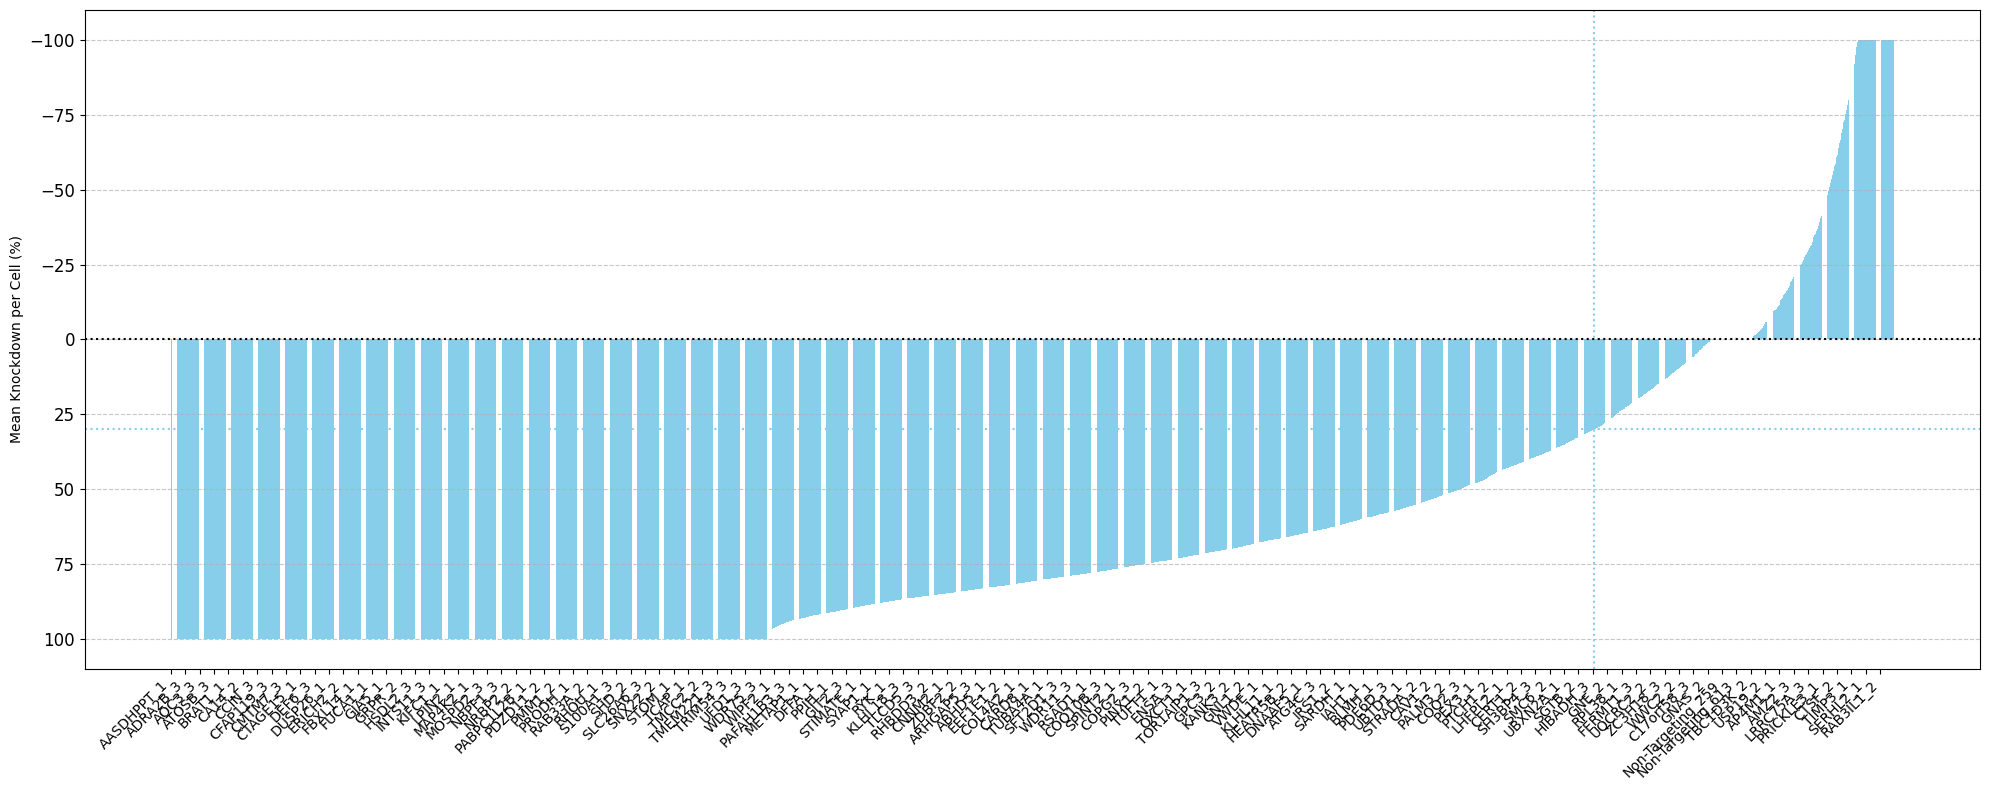

Removing 1851 perturbing sgRNA for not having more than 30% knockdown
Before filter: 11997,perturbed
True     638621
False      9181
Name: count, dtype: int64
After filter: 10146,perturbed
True     542689
False      9181
Name: count, dtype: int64
Removing 22342 perturbed cells for not having any measureable repression.
Before filter: 10146,perturbed
True     542689
False      9181
Name: count, dtype: int64
After filter: 10146,perturbed
True     520347
False      9181
Name: count, dtype: int64


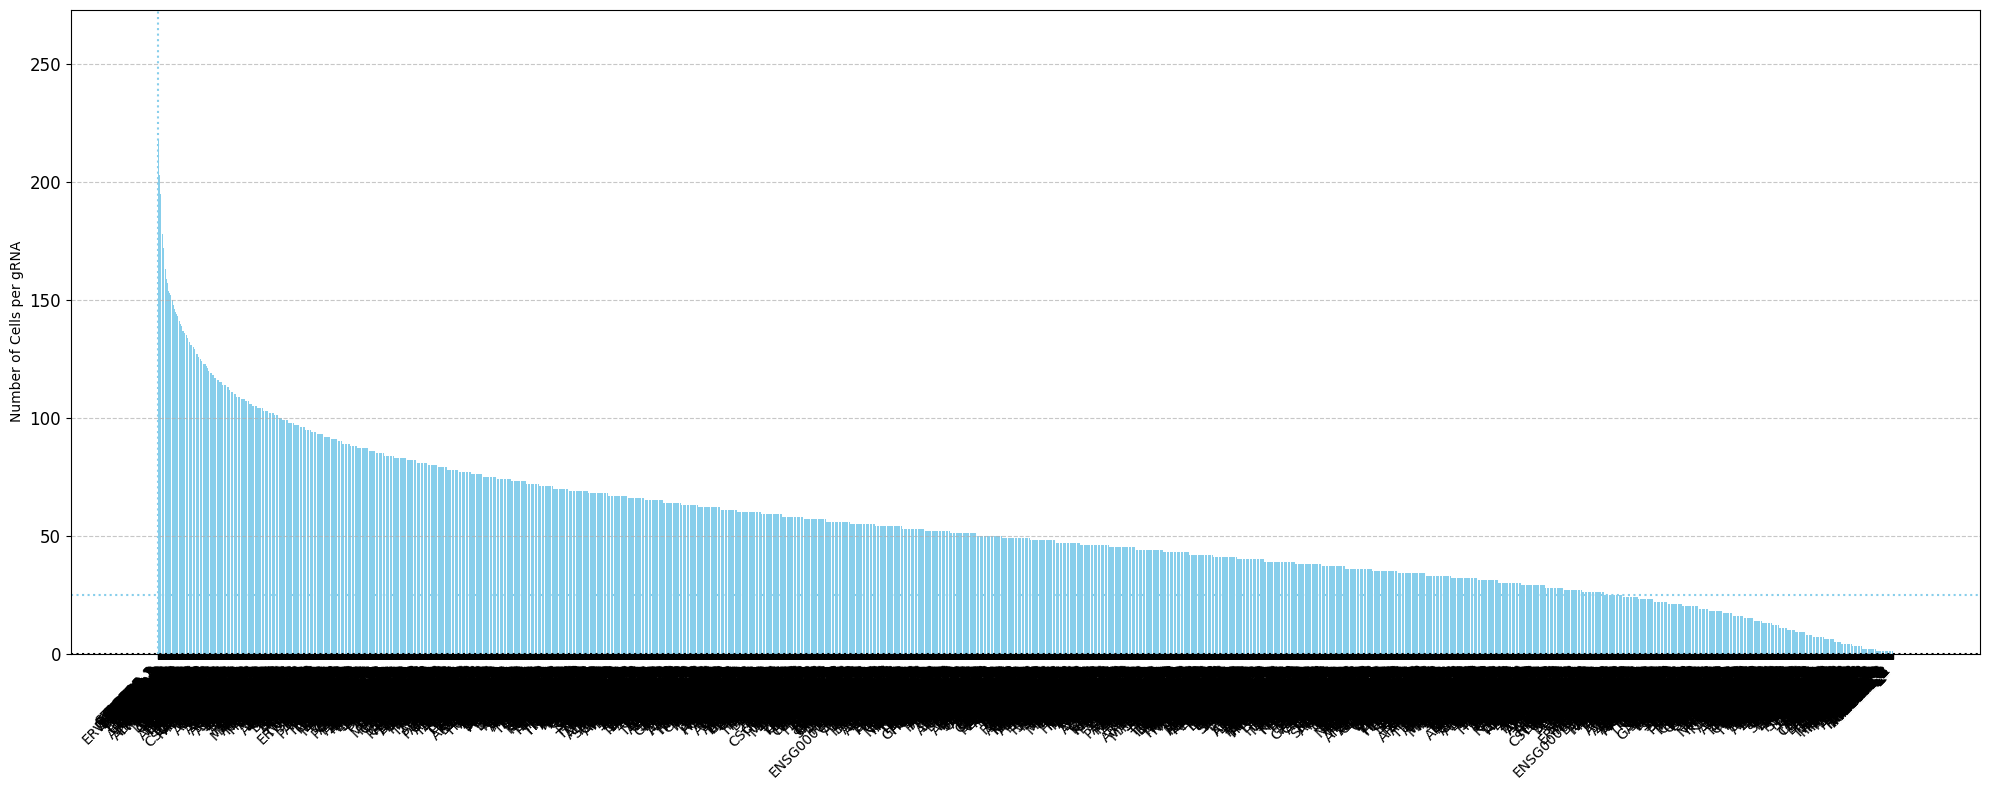

Before filter: 10146,perturbed
True     520347
False      9181
Name: count, dtype: int64
Removing 1650 perturbing sgRNA for not having more than 25 cells
After filter: 8496,perturbed
True     497445
False      9181
Name: count, dtype: int64


In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_final.h5ad")
knockdown_adata_gamma = qc2.knockdown_qc(adata_gamma, 'gene_target_ensembl_id', 'gene_ids').copy()

9567/11739 (0.8149757219524661) Perturbations achieve > 30% Knockdown


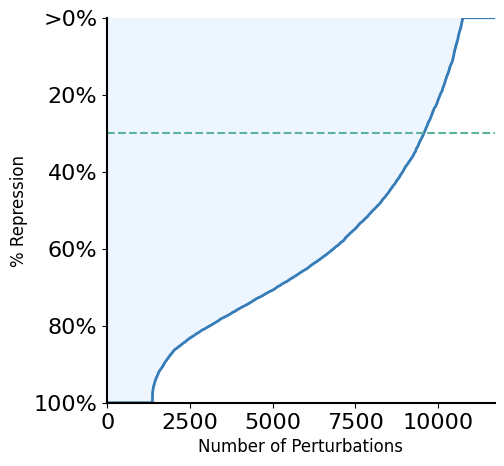

In [ ]:
alpha_knockdown = list(qc2._get_perturbed_view(adata_alpha).obs.groupby("gene_target")["target_knockdown"].mean())
beta_knockdown = list(qc2._get_perturbed_view(adata_beta).obs.groupby("gene_target")["target_knockdown"].mean())
gamma_knockdown = list(qc2._get_perturbed_view(adata_gamma).obs.groupby("gene_target")["target_knockdown"].mean())
total_knockdown = np.sort(np.clip(np.array(alpha_knockdown + beta_knockdown + gamma_knockdown),a_min=0,a_max=1))[::-1]
f = qc2.plot_percentage_perturbations_by_repression(total_knockdown)

Calculate median NTC number of UMI counts:

In [ ]:
median_NTC = np.median(list(qc2._get_ntc_view(knockdown_adata_alpha).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_beta).obs.n_UMI_counts) 
                       + list(qc2._get_ntc_view(knockdown_adata_gamma).obs.n_UMI_counts))
print(median_NTC)

4540.0


Normalize, log1p transform, and scale data with target sum `median_NTC`, one dataset at a time.

ALPHA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_alpha,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_alpha)
sc.pp.scale(knockdown_adata_alpha)

normalizing counts per cell
    finished (0:00:08)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_alpha.write("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

In [ ]:
del knockdown_adata_alpha
gc.collect()

1550519

BETA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_beta,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_beta)
sc.pp.scale(knockdown_adata_beta)

normalizing counts per cell
    finished (0:00:07)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_beta.write("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

In [ ]:
del knockdown_adata_beta
gc.collect()

900

GAMMA:

In [ ]:
sc.pp.normalize_total(knockdown_adata_gamma,target_sum=median_NTC)
sc.pp.log1p(knockdown_adata_gamma)
sc.pp.scale(knockdown_adata_gamma)

normalizing counts per cell
    finished (0:00:05)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
knockdown_adata_gamma.write("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

Restart kernel

## Step F: Isolate sgRNA altering cell state and isolate perturbed cells

### Step F with modified RNG functions (PCA seeds both = 0)

First we perform sgRNA-level energy distance-based filtering on each of the 3 data subsets.

In [ ]:
# Settings for parallel processing with tqdm_joblib
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"
os.environ["KMP_WARNINGS"] = "0"  # For Intel's OpenMP implementation

# Create numpy default_rng() RNG object
step_f_rand_seed = 1337
step_f_rng = np.random.default_rng(step_f_rand_seed)

ALPHA:

In [ ]:
knockdown_adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_ALPHA_final.h5ad")

In [ ]:
knockdown_adata_alpha

AnnData object with n_obs × n_vars = 593295 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_alpha.obs.perturbed.value_counts()

perturbed
True     579997
False     13298
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:18)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:30)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/7406 [00:00<?, ?it/s]

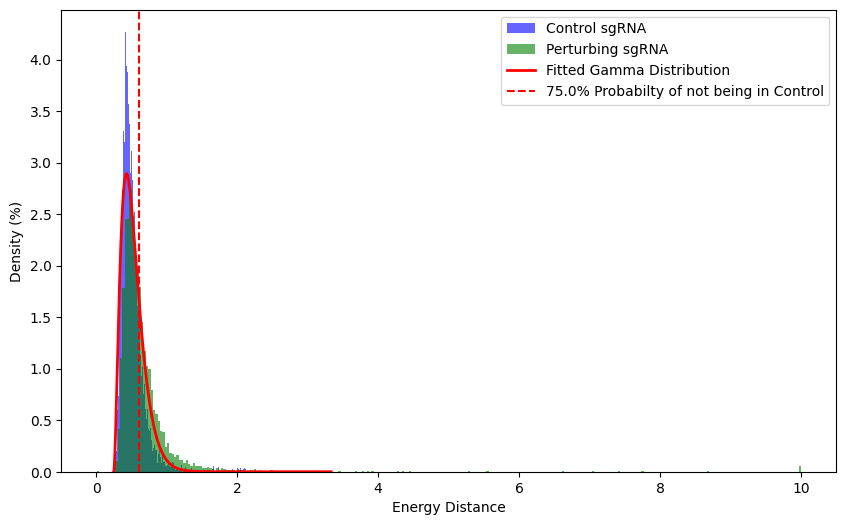

2939/7406 Perturbing sgRNA cross threshold of 0.75


In [ ]:
alpha_filtered, alpha_null_distances, alpha_results = qc2.filter_sgRNA_rng(knockdown_adata_alpha, rng=step_f_rng)

In [ ]:
alpha_filtered = alpha_filtered.copy()

In [ ]:
alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
del alpha_filtered
gc.collect()

37401

BETA:

In [ ]:
knockdown_adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_BETA_final.h5ad")

In [ ]:
knockdown_adata_beta

AnnData object with n_obs × n_vars = 716558 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_beta.obs.perturbed.value_counts()

perturbed
True     703808
False     12750
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:11)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8766 [00:00<?, ?it/s]

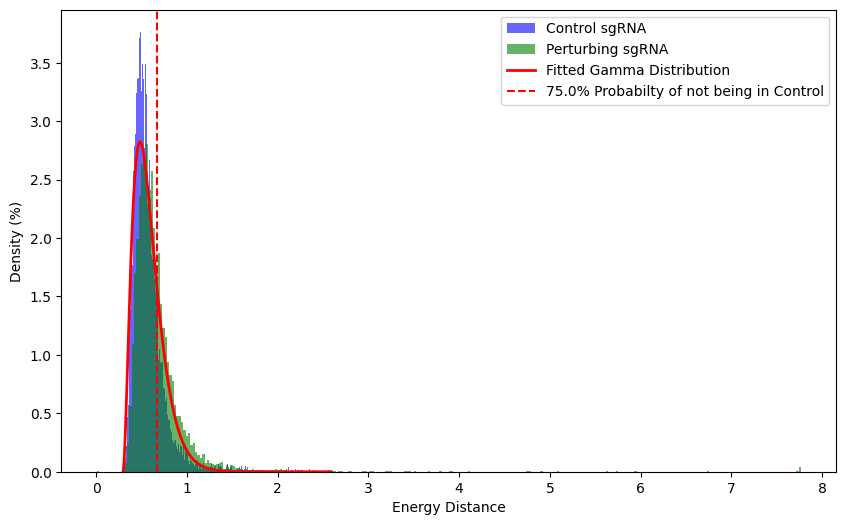

3194/8766 Perturbing sgRNA cross threshold of 0.75


In [ ]:
beta_filtered, beta_null_distances, beta_results = qc2.filter_sgRNA_rng(knockdown_adata_beta, rng=step_f_rng)

In [ ]:
beta_filtered = beta_filtered.copy()

In [ ]:
beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

In [ ]:
del beta_filtered
gc.collect()

37610

GAMMA:

In [ ]:
knockdown_adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/step_E_output_GAMMA_final.h5ad")

In [ ]:
knockdown_adata_gamma

AnnData object with n_obs × n_vars = 506626 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

In [ ]:
knockdown_adata_gamma.obs.perturbed.value_counts()

perturbed
True     497445
False      9181
Name: count, dtype: int64

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:06)
    computed connectivities (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


Computing null distribution:   0%|          | 0/20 [00:00<?, ?it/s]

Computing group distances:   0%|          | 0/8262 [00:00<?, ?it/s]

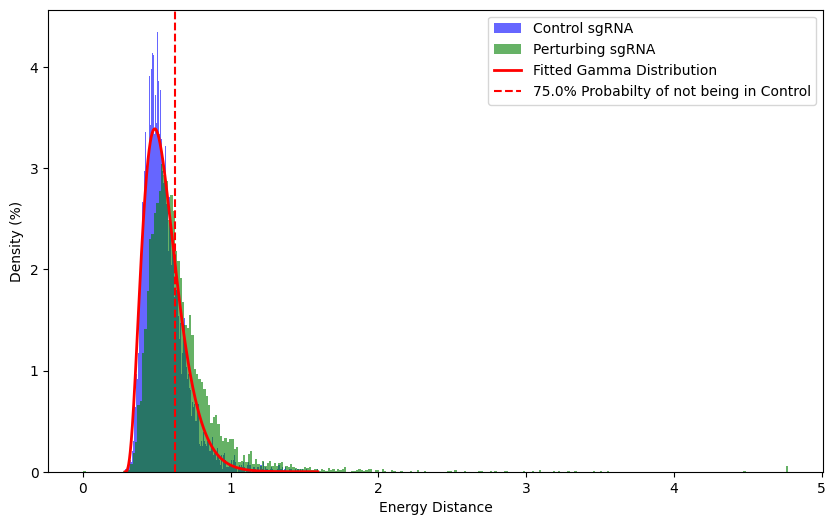

3541/8262 Perturbing sgRNA cross threshold of 0.75


In [ ]:
gamma_filtered, gamma_null_distances, gamma_results = qc2.filter_sgRNA_rng(knockdown_adata_gamma, rng=step_f_rng)

In [ ]:
gamma_filtered = gamma_filtered.copy()

In [ ]:
gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

Restart kernel

Next, we remove unperturbed cells one data subset at a time using an SVM classifier. The SVM is trained on the PCA embedding of the dataset. KO cells that are classified as NTC cells by the SVM will be removed.

In [ ]:
step_f_rm_rand_seed = 0 # PCA random_state

ALPHA:

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_sgRNA_Filtered_final.h5ad")

In [ ]:
adata_alpha

AnnData object with n_obs × n_vars = 235798 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'log1p'
    layers: 'counts', 'normalized_counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:17)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


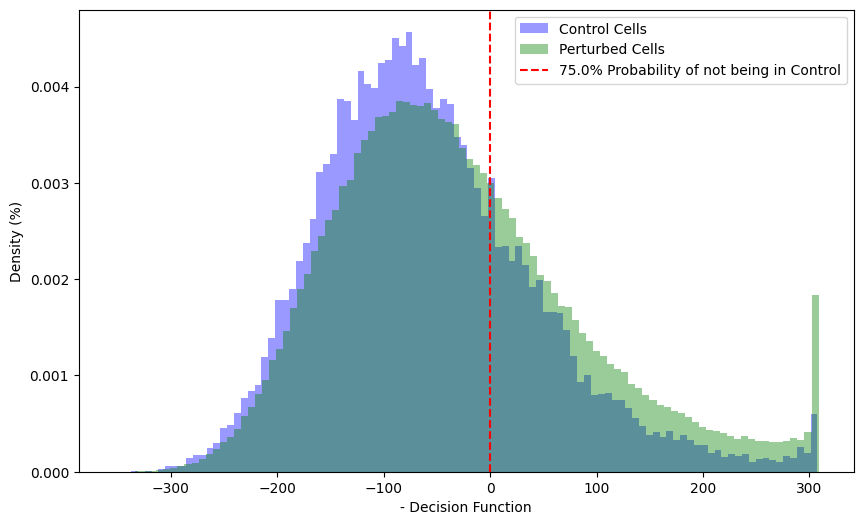

75190/222500 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_alpha_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_alpha, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_alpha_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1333 ['NTC', 'KAT2A', 'ARHGAP35', 'LRPPRC', 'CABIN1', 'ZNF787', 'ZFP82', 'ESRRG', 'DNMT1', 'NPM2', 'EHMT1', 'TENT4B', 'VDR', 'PCGF1', 'FOXH1', 'TSFM', 'INTS12', 'PNPT1', 'ZNF20', 'EZH2', 'ZSCAN18', 'ZNF396', 'ARNT2', 'UHRF1', 'PGR', 'TFAM', 'METTL24', 'CDYL2', 'KMT5C', 'ZNF521', 'ZNF875', 'ELOA', 'SMARCC1', 'DHX36', 'EHMT2', 'RNASEH1', 'DDX6', 'PAXIP1', 'DFFB', 'ZFP37', 'GNMT', 'DBX2', 'METTL7B', 'ANKZF1', 'ZNF362', 'MTA1', 'SMARCE1', 'SHOX2', 'HNF1A', 'POU5F1', 'LEMD3', 'KDM4B', 'H2BK1', 'ZNF426', 'ACTB', 'SUZ12', 'SOX4', 'MED19', 'SCX', 'POLRMT', 'RNF2', 'JMJD8', 'PPARGC1B', 'NABP2', 'POGZ', 'ZNF276', 'ACSF2', 'TRIM37', 'SCAI', 'KMT2D', 'UBR3', 'NEUROD4', 'SETDB1', 'DOT1L', 'FOXJ1', 'NCOA7', 'RCOR2', 'CDK13', 'SMAD4', 'CHAMP1', 'NANOG', 'H4C2', 'FOXD4', 'RLIM', 'EMSY', 'ZFP92', 'SETD7', 'ZNF551', 'BARX1', 'ZNF44', 'BARHL1', 'ZNF687', 'OVOL1', 'ZNF280B', 'ASF1A', 'MLLT1', 'SIN3B', 'EID1', 'ZNF469', 'SLC27A1', 'ZNF358', 'CCDC85B', 'HEXIM1', 'HHEX', 'GATAD1', 'IRF9', 'PARP16', 'SCRT2', 

In [ ]:
adata_alpha_filtered = qc2.remove_perturbations_by_cell_threshold(adata_alpha_filtered)

Removing 749 perturbations for having under 25 cells.


In [ ]:
adata_alpha_filtered

AnnData object with n_obs × n_vars = 75341 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_alpha_filtered.write("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells_final.h5ad")

In [ ]:
del adata_alpha, adata_alpha_filtered
gc.collect()

16720

BETA:

In [ ]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


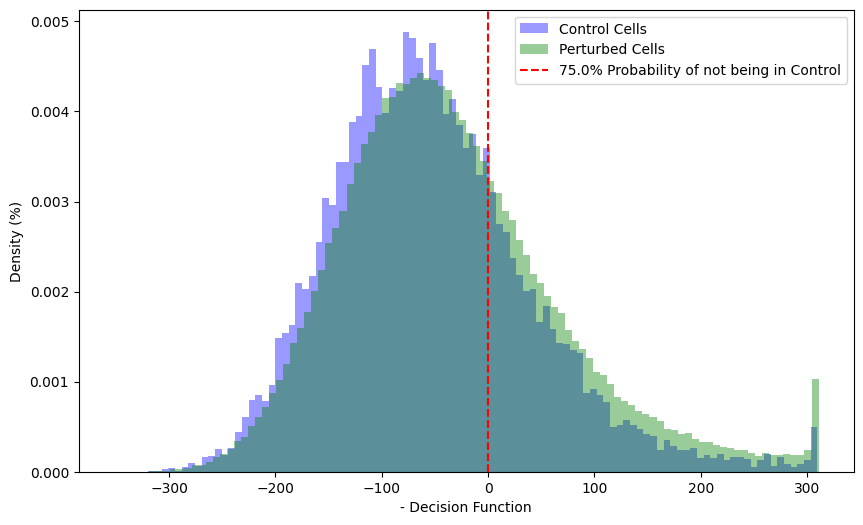

76834/245988 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_beta_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_beta, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_beta_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1353 ['NTC', 'CASP6', 'CCDC6', 'SLC39A13', 'BBC3', 'HCCS', 'VPS33A', 'VHL', 'UBE2M', 'RGS19', 'SLC30A1', 'MZT2A', 'UBFD1', 'PLIN3', 'ENHO', 'FBXO45', 'B3GAT3', 'LATS2', 'DTD2', 'SEMA6C', 'NAE1', 'PGM1', 'RNPEPL1', 'NDUFAF4', 'CRYGD', 'PDPR', 'ANKRD39', 'ANKRD9', 'FASTKD5', 'DESI2', 'LAMTOR1', 'PLOD3', 'ARFGAP1', 'TEFM', 'ORMDL1', 'MTHFR', 'CDKN2AIPNL', 'CYCS', 'TMEM98', 'IGF2R', 'IFFO1', 'ARSA', 'S100A11', 'TESK1', 'WDR91', 'TBRG4', 'JOSD1', 'RASL10B', 'AK4', 'INPP5J', 'PRSS53', 'STEAP3', 'AMOTL2', 'CHP2', 'LAMTOR5', 'IKBIP', 'MRPL36', 'ARL4D', 'HRH3', 'FXYD6', 'VPS39', 'MRPL11', 'POGLUT3', 'OSBPL2', 'FUOM', 'UNC50', 'ETNK2', 'SOCS1', 'TAGLN2', 'KHDC4', 'MTRES1', 'TNKS2', 'HNRNPM', 'DSP', 'PLA2G12A', 'HMBS', 'ZFAND2B', 'CSTB', 'UFSP1', 'CDO1', 'MRPS27', 'CTSL', 'MRPL10', 'FBXO2', 'TOE1', 'CKAP2', 'IFFO2', 'RUSF1', 'APMAP', 'CRELD1', 'WFS1', 'COX6B1', 'MRPL24', 'PCDH1', 'FNDC4', 'SRRD', 'LRFN3', 'MRPL58', 'GPR62', 'ADRA2C', 'FCHSD1', 'RAB5A', 'MYADM', 'GOLGA5', 'ELAVL1', 'CNOT11', 'MYL9

In [ ]:
adata_beta_filtered = qc2.remove_perturbations_by_cell_threshold(adata_beta_filtered)

Removing 945 perturbations for having under 25 cells.


In [ ]:
adata_beta_filtered

AnnData object with n_obs × n_vars = 73543 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_beta_filtered.write("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells_final.h5ad")

In [ ]:
del adata_beta, adata_beta_filtered
gc.collect()

17401

GAMMA:

In [ ]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_sgRNA_Filtered_final.h5ad")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:02)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


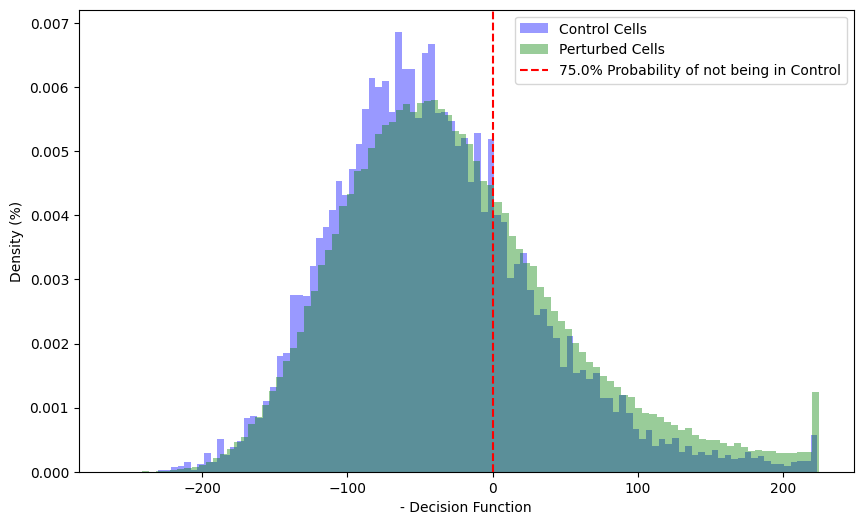

64218/207387 Perturbed Cells cross threshold of 0.75


In [ ]:
adata_gamma_filtered, c, p = qc2.remove_unperturbed_cells_random_seed(
    adata_gamma, threshold=0.75, rand_seed=step_f_rm_rand_seed)

In [ ]:
perturbation_counts = dict(adata_gamma_filtered.obs.gene_target.value_counts())
remaining_perturbations = [k for k,v in perturbation_counts.items() if v >= 25]
print(len(remaining_perturbations),remaining_perturbations)

1070 ['NTC', 'FLYWCH2', 'SUPT20H', 'NF2', 'ABCD1', 'HS2ST1', 'FAM193A', 'C15orf61', 'DDT', 'BAK1', 'FLCN', 'RALGAPB', 'IL17RD', 'STOML1', 'CDC42EP1', 'VSIG10', 'TIMM50', 'FGF21', 'CTAGE15', 'CHRD', 'DNAL4', 'NPC1', 'FECH', 'ADCY9', 'EIF4ENIF1', 'CDON', 'TGFBR2', 'EFNB3', 'MPC2', 'SCAF8', 'TMEM74B', 'SYT7', 'USP45', 'DAP', 'AKAP9', 'BAD', 'SLC35F5', 'PLXND1', 'ARL3', 'RPL39L', 'UNC5B', 'DTX2', 'CAB39', 'ERO1A', 'DECR2', 'SPAG9', 'HIBADH', 'CAMK2N2', 'PAQR3', 'TSEN54', 'CISD3', 'TBC1D7', 'FAM98A', 'KTN1', 'GDAP1', 'POMT2', 'NCAN', 'AGTPBP1', 'UQCC1', 'C1orf21', 'PAPSS1', 'WASHC2C', 'AP5S1', 'TIE1', 'PEX13', 'NPIPA3', 'BCL2L12', 'OSBPL7', 'CYP2R1', 'MBOAT1', 'WNK2', 'SH3D19', 'FLT1', 'GOLGA6A', 'HPRT1', 'DSE', 'C18orf32', 'BEND4', 'RNF11', 'CNST', 'MCOLN1', 'HEATR6', 'RETREG2', 'KLHL24', 'RET', 'KLHL4', 'NRBP1', 'FRAS1', 'SLC25A51', 'FAM221A', 'TAC1', 'MAP4K5', 'BLTP1', 'CYP2D6', 'MTPAP', 'APAF1', 'CYBRD1', 'NADK2', 'DNAJC16', 'SLC29A2', 'EDNRB', 'GARIN5A', 'GCSAM', 'CCDC87', 'DFFA', 'USP

In [ ]:
adata_gamma_filtered = qc2.remove_perturbations_by_cell_threshold(adata_gamma_filtered)

Removing 1408 perturbations for having under 25 cells.


In [ ]:
adata_gamma_filtered

AnnData object with n_obs × n_vars = 52126 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '

In [ ]:
adata_gamma_filtered.write("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells_final.h5ad")

Restart kernel